In [1]:
from __future__ import absolute_import, division, print_function

import sys
import skimage.io
import numpy as np
import tensorflow as tf
import json
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../')

from models import text_objseg_model as segmodel
from util import im_processing, text_processing

In [2]:
# input image and query text
im_file = './demo_data/7.jpg'
query = 'the man on horse'

# trained model
pretrained_model = '../exp-referit/tfmodel/referit_fc8_seg_highres_iter_18000.tfmodel'
#pretrained_model = '../exp-referit/tfmodel/referit_fc8_seg_highres_iter_18000.tfmodel.data-00000-of-00001'
vocab_file = '../exp-referit/data/vocabulary_referit.txt'

In [3]:
# Load the model
# Model Param
T = 20
N = 1
input_H = 512; featmap_H = (input_H // 32)
input_W = 512; featmap_W = (input_W // 32)
num_vocab = 8803
embed_dim = 1000
lstm_dim = 1000
mlp_hidden_dims = 500

# Inputs
text_seq_batch = tf.placeholder(tf.int32, [T, N])
imcrop_batch = tf.placeholder(tf.float32, [N, input_H, input_W, 3])

# Outputs
scores = segmodel.text_objseg_upsample32s(text_seq_batch, imcrop_batch, num_vocab,
                                          embed_dim, lstm_dim, mlp_hidden_dims,
                                          vgg_dropout=False, mlp_dropout=False)[1]

# Load pretrained model
snapshot_restorer = tf.train.Saver()
sess = tf.Session()
snapshot_restorer.restore(sess, pretrained_model)

'''
# Load pretrained model
snapshot_restorer = tf.train.import_meta_graph('../exp-referit/tfmodel/referit_fc8_seg_highres_iter_18000.tfmodel.meta')
sess = tf.Session()

#init_op = tf.global_variables_initializer()
#sess.run(init_op)

snapshot_restorer.restore(sess, tf.train.latest_checkpoint('../exp-referit/tfmodel/'))
'''

# Load vocabulary
vocab_dict = text_processing.load_vocab_dict_from_file(vocab_file)

In [4]:
# Run on the input image and query text
text_seq_val = np.zeros((T, N), dtype=np.float32)
imcrop_val = np.zeros((N, input_H, input_W, 3), dtype=np.float32)

# Preprocess image and text
im = skimage.io.imread(im_file)
processed_im = skimage.img_as_ubyte(im_processing.resize_and_pad(im, input_H, input_W))
imcrop_val[0, :] = processed_im.astype(np.float32) - segmodel.vgg_net.channel_mean
text_seq_val[:, 0] = text_processing.preprocess_sentence(query, vocab_dict, T)

# Forward pass to get response map
scores_val = np.squeeze(sess.run(scores, feed_dict={text_seq_batch: text_seq_val,
                                                    imcrop_batch: imcrop_val}))

print("Hello")
# Final prediction
prediction = im_processing.resize_and_crop(scores_val>0, *im.shape[:2]).astype(np.bool)

c:\python35\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


Hello


query text = 'the man on horse'


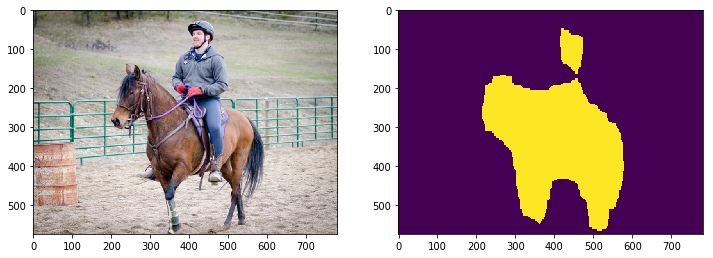

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(prediction)

print("query text = '%s'" % query)